# Coding Exercises

*You may want to revise this before a Data Science coding interview*

## Imports and styling

In [1]:
import os
import sys
import io
import zipfile
import datetime
import itertools
import functools
import collections
import cloudpickle
import sqlite3
import numpy as np
import pandas as pd
import scipy
from loguru import logger
# import ipdb

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet, LassoLarsCV, RidgeCV, LogisticRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, confusion_matrix, balanced_accuracy_score, precision_recall_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample, shuffle

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
import lightgbm as lgb
import skopt
import shap

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.graph_objects as go

np.random.seed(42**3)

In [2]:
logger.remove()
logger.add(sys.stderr, format='{time} {level} {line}: {message}', level='DEBUG')

plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (5, 5)

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100

def ht(df, n=2):
    display(pd.concat([df.head(n), df.tail(n)]))

## Custom models

In [3]:
class MinMaxClipper(TransformerMixin, BaseEstimator):
    def fit(self, X, y):
        self.x_min_ = np.min(X)
        self.x_max_ = np.max(X)
        return self
        
    def transform(self, X):
        return X.clip(self.x_min_, self.x_max_, axis=1)

class FixedGAM(RegressorMixin, BaseEstimator):
    def __init__(self, df=5, degree=3, alpha=0.1):
        self.df = df
        self.degree = degree
        self.alpha = alpha
    
    def fit(self, X, y):
        X = np.array(X)
        self.x_min_ = np.min(X, axis=0)
        self.x_max_ = np.max(X, axis=0)
        self.splines_ = BSplines(X, df=[self.df] * X.shape[1], degree=[self.degree] * X.shape[1]) 
        self.estimator_ = GLMGam(y, X, smoother=self.splines_, alpha=self.alpha)
        self.res_ = self.estimator_.fit()
        return self
    
    def predict(self, X):
        X = np.clip(X, self.x_min_, self.x_max_)
        return self.res_.predict(X, exog_smooth=X)

## Utility

In [4]:
def _get_value_range(x):
    vals = np.array(x.dropna().unique())
    if isinstance(vals, np.object) and len(vals) < 10:
        return f'{vals}'
    else:
        return f'{vals.min()} - {vals.max()}'

def describe_df(df):
    df_nan_rate = df.isnull().sum().rename('nans') / len(df)
    df_dtype = df.dtypes
    df_values = df.apply(_get_value_range, axis=0)

    df_desription = pd.DataFrame({
        'nan_rate': df_nan_rate,
        'dtype': df_dtype,
        'values': df_values,
    }).sort_values('nan_rate')
    return df_desription

# Hackerrank: Laptop Charge

In [11]:
df = pd.read_csv('laptop_data.txt', sep=',', header=None, dtype=float, names=['charge', 'work'])
df = df.sort_values('charge')
ht(df)

,charge,work
19,0.00,0.00
27,0.02,0.04
36,9.71,8.00
59,11.72,8.00


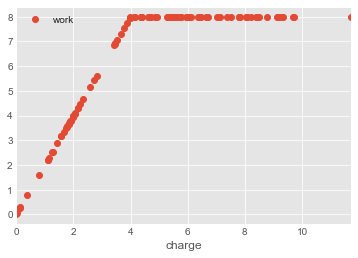

In [24]:
_ = df.plot(x='charge', y='work', style='o')

# Hackerrank: The Best Aptitude Test

['input/', 'input/input01.txt', 'output/', 'output/output01.txt']


0    7.5
1    7.7
2    7.9
3    8.1
4    8.3
dtype: float64

,0,1,2,3,4
0,10.0,11.0,21.0,91.0,81.0
1,30.0,9.0,9.0,9.0,99.0
2,20.0,5.0,15.0,75.0,55.0
3,40.0,19.0,19.0,19.0,59.0
4,50.0,29.0,39.0,89.0,89.0


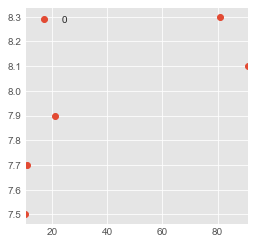

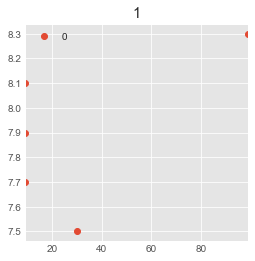

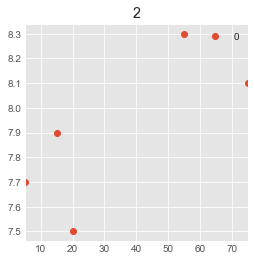

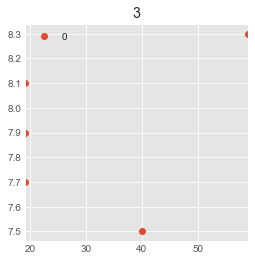

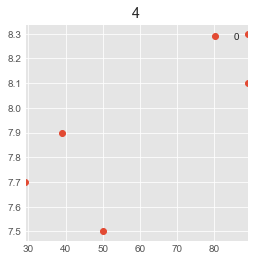

In [39]:
with zipfile.ZipFile('the-best-aptitude-test-testcases.zip') as z:
    print(z.namelist())
    with z.open('input/input01.txt') as f:
        inp = f.read()
inp = [x.split() for x in inp.decode().split('\n')[2:]]
y = pd.Series(inp[0], dtype=float)
X = pd.DataFrame(inp[1:], dtype=float).T
display(y)
display(X)

for i, row in X.iterrows():
    pd.Series(y.values, index=row.values).to_frame().plot(lw=1, title=i, style='o', figsize=(4, 4))

In [40]:
correlations = []
for i, row in X.T.iterrows():
    correlations.append(np.corrcoef(y, row)[0, 1])
print(correlations.index(max(correlations))+1)

1


In [41]:
t = RFE(LinearRegression(), n_features_to_select=1)
t.fit(X, y)
print(np.argmin(t.ranking_)+1)

1


# Kojino: Vector Assignments

In [6]:
# [0, 1] -> 
#     [0], [1]
#     [1], [0]
# [0, 1, 2, 3] -> 
#     [0, 1], [2, 3]
#     [0, 2], [1, 3]
#     [0, 3], [1, 2]
#     [1, 2], [0, 3]
#     [1, 3], [0, 2]
#     [2, 3], [0, 1]

In [43]:
n = 4
assert n % 2 == 0

k = n // 2
samples = np.arange(n)
for i in range(2**n):
    b = bin(i)[2:].zfill(n)
#     print('.', b)
    if b.count('1') == k:
        idx1 = np.array(list(b), dtype=int).astype(bool)
        print(samples[idx1], samples[~idx1])

[2 3] [0 1]
[1 3] [0 2]
[1 2] [0 3]
[0 3] [1 2]
[0 2] [1 3]
[0 1] [2 3]


# Kojino: Sqare root

In [4]:
num = 2
scipy.optimize.root_scalar(lambda x: x**2 - num, x0=1, x1=1.1, method='secant')

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 1.4142135623730951

In [5]:
# 0 = f(x1) = f(x0) + f'(x0) * (x1-x0) => x1 = x0 - f(x0)/f'(x0)

def secant_root_finder(f, x0, x1, eps=0.001, max_iter=15):
    count = 0
    f0 = f(x0)
    f1 = f(x1)
    while (abs(f1) > eps) and (count < max_iter):
        x0, x1 = x1, x1 - f1 * (x1 - x0) / (f1 - f0)
        f0, f1 = f1, f(x1)
        count += 1
    logger.debug(f'count = {count}')
    return x1

secant_root_finder(lambda x: x**2 - num, x0=1, x1=1.1)

2020-03-09 20:20:33.803 | DEBUG    | __main__:secant_root_finder:11 - count = 3
2020-03-09T20:20:33.803113+0000 DEBUG: count = 3


1.4140510503175379

# Kojino: Outliers

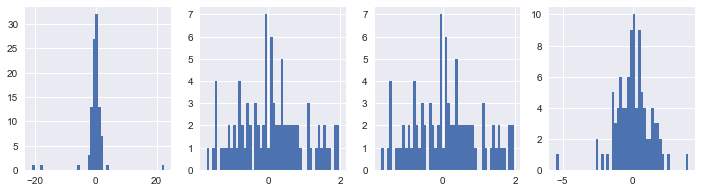

In [55]:
fig, ax = plt.subplots(1, 4, sharex=False, figsize=(12, 3))

# arr = np.random.standard_cauchy(100)
distr_mask=np.random.choice([1, 0], p=[0.9, 0.1], size=100)
arr = np.random.normal(scale=1, size=100) * distr_mask + np.random.normal(scale=10, size=100) * np.logical_not(distr_mask)
_ = ax[0].hist(arr, bins=50)

arr1 = arr[np.argsort(np.abs(arr))[:-10]]
_ = ax[1].hist(arr1, bins=50)

arr2 = arr[np.abs(arr) < 10]
_ = ax[2].hist(arr1, bins=50)

arr3 = arr[scipy.stats.zscore(arr) < 3]
_ = ax[3].hist(arr2, bins=50)

# Toptal: Quicksort

In [9]:
# [3, 4, 1, 1, 42, -4] => [-4, 1, 1, 3, 4, 42]

def quick_sort(a, i=0, j=None):
    if j is None:
        j = len(a)-1
    logger.debug(a[i: j+1])
    if j-i < 1:
        pass
    elif j-i == 1:
        if a[i] > a[j]:
            a[i], a[j] = a[j], a[i]
    else:
        pv = a[i]
        cidx = i
        for ind in range(i+1, j+1):
            if a[ind] < pv:
                a[cidx], a[cidx+1], a[ind] = a[ind], pv, a[cidx+1]
                cidx += 1
        quick_sort(a, i, cidx-1)
        quick_sort(a, cidx+1, j)
        
arr = [3, 4, 1, 1, 42, -4]
quick_sort(arr)
print(arr)

2020-03-10T20:20:20.530795+0000 DEBUG 6: [3, 4, 1, 1, 42, -4]
2020-03-10T20:20:20.531794+0000 DEBUG 6: [1, 1, -4]
2020-03-10T20:20:20.532795+0000 DEBUG 6: [-4]
2020-03-10T20:20:20.533795+0000 DEBUG 6: [1]
2020-03-10T20:20:20.534793+0000 DEBUG 6: [42, 4]


[-4, 1, 1, 3, 4, 42]


# Random ML: Linear Regression

In [9]:
class CustomLR(RegressorMixin, BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        # y = X*b + e
        # (y - X*b) ^ 2 -> min  =>  -2*X_T * (y - X*b) = 0  =>  X_T*y = X_T*X*b  =>  b = (X_T*X)^(-1) * X_T * y
        X = np.array(X)
        y = np.array(y)
        assert len(X.shape) == 2
        assert len(y.shape) == 1
        self.coef_ = scipy.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
#         self.coef_ = scipy.linalg.lstsq(X, y)[0]
        return self
        
    def predict(self, X):
        X = np.array(X)
        assert len(X.shape) == 2
        return np.dot(X, self.coef_)
    
    
X = np.random.normal(size=(100, 3))
y = X[:, 0] + 2*X[:, 1] - 2*X[:, 2] + np.random.normal(scale=0.1, size=100)

m = CustomLR()
m.fit(X, y)
y_hat = m.predict(X)
print(m.coef_)
print(mean_squared_error(y, y_hat))

[ 1.00623129  1.98369705 -2.00640157]
0.008251081288529258


# Random ML: Stats

In [23]:
# - covariance and correlation

a = np.array([1, 1, -1, -1])
b =  np.array([4, 4, -4, -4])
cov = np.mean((a - a.mean()) * (b - b.mean()))
corr = cov / np.sqrt(np.mean((a - a.mean()) ** 2)) / np.sqrt(np.mean((b - b.mean()) ** 2))
print('cov', cov.round(3))
print('corr', corr.round(3))

cov 4.0
corr 1.0


t-test pval for equal means =  0.5858332297333354
MC simulation proba for mean diff less than 0.1 = 0.953


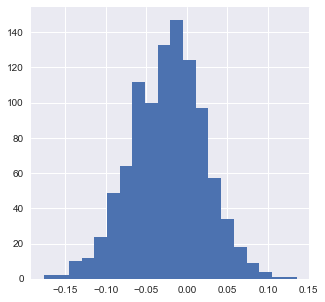

In [91]:
# - t-test and monte-carlo for sample means

a = np.random.normal(0, 1, size=1000)
b = np.random.normal(0, 1, size=1000)

tstat, tpval = scipy.stats.ttest_ind(a, b, equal_var=False)
print('t-test pval for equal means = ', tpval)

n = 1000
a_b_mean_diff = []
for i in range(n):
    a_mean = np.mean(np.random.choice(a, size=len(a), replace=True))
    b_mean = np.mean(np.random.choice(b, size=len(b), replace=True))
    a_b_mean_diff.append(a_mean-b_mean)
a_b_mean_diff = np.array(sorted(a_b_mean_diff))
_ = plt.hist(a_b_mean_diff, bins=20)
ci = 0.1
print(f'MC simulation proba for mean diff less than {ci} = {np.sum(np.abs(a_b_mean_diff) < ci) / len(a_b_mean_diff)}')

# Workera: Dataset stats

In [120]:
df = pd.DataFrame({
    'a': np.arange(20),
    'b': np.arange(20),
    'c': np.linspace(0, 1, 20) ** 2,
})
df['d'] = df['a'] + df['b'] + df['c'] * 5 + np.random.normal(0, 1., size=20)

ht(df)
display(df.agg(['mean', 'median', 'var', 'std'], axis=0))

corr_mtx = df[['a', 'b', 'c']].corr()
display(corr_mtx.round(2))
for i in range(0, corr_mtx.shape[0]):
    for j in range(i+1, corr_mtx.shape[0]):
        if corr_mtx.iloc[i, j] > 0.99:
            print('collinear columns:', df.columns[i], df.columns[j], corr_mtx.iloc[i, j])
df = df.drop(columns='b')

# d = a + c + e, e~N(0, sigma2)

X = df.drop(columns='d')
y = df['d']
mres = sm.OLS(y, exog=X).fit()
display(mres.summary())
# print(mres.params)

print()
m = LinearRegression(fit_intercept=False)
m.fit(X, y)
display(pd.Series(m.coef_, index=X.columns).rename('coeffients').to_frame().T)
y_hat = m.predict(X)
resid = np.array(y) - y_hat
sigma2_hat = np.var(resid, ddof=1+X.shape[1])
print(f'sigma2_hat = {sigma2_hat:.2f}')
a_mean = m.coef_[0]
a_std = np.sqrt(sigma2_hat * np.linalg.inv(np.dot(X.T, X))[0, 0])
z_score_a = a_mean / a_std
print(f'z_score_a = {z_score_a:.2f}')

c1_a_t = scipy.stats.t.ppf(0.025, df=20-2-1)
c2_a_t = scipy.stats.t.ppf(0.975, df=20-2-1)
c1_a = a_mean + c1_a_t * a_std
c2_a = a_mean + c2_a_t * a_std
print(f'95% confidence interval a = {[c1_a.round(2), c2_a.round(2)]}')

,a,b,c,d
0,0,0,0.000000,-0.709352
1,1,1,0.002770,2.708759
18,18,18,0.897507,38.818736
19,19,19,1.000000,43.879562


,a,b,c,d
mean,9.50000,9.50000,0.342105,20.641497
median,9.50000,9.50000,0.250693,19.132547
var,35.00000,35.00000,0.104043,179.518623
std,5.91608,5.91608,0.322557,13.398456


,a,b,c
a,1.00,1.00,0.97
b,1.00,1.00,0.97
c,0.97,0.97,1.00


collinear columns: a b 1.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      d   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              6918.
Date:                Sat, 14 Mar 2020   Prob (F-statistic):                    1.05e-26
Time:                        18:37:02   Log-Likelihood:                         -25.831
No. Observations:                  20   AIC:                                      55.66
Df Residuals:                      18   BIC:                                      57.65
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
a              1.9782      0.075     26.442      0.000       1.821       2.135
c              5.3734      1.789      3.003      0.008       1.614       9.133
==============================================================================
Omnibus:                        2.815   Durbin-Watson:                   2.473
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                1.295
Skew:                          -0.575   Prob(JB):                        0.523
Kurtosis:                       3.480   Cond. No.                         96.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

a    1.978236
c    5.373405
dtype: float64



,a,c
coeffients,1.978236,5.373405


sigma2_hat = 0.91
z_score_a = 25.70
95% confidence interval a = [1.82, 2.14]


# Workera: Confidence interval

In [109]:
n = 30
p = 1./3
sigma = np.sqrt(p * (1-p) / (n - 1))

# - approximate at normal (using CDF inverse)
print(f'conf interval = {scipy.stats.norm.ppf([0.025, 0.975], loc=p, scale=sigma)}')

# - approximate at normal (using CDF)
c1 = scipy.optimize.root_scalar(lambda x: scipy.stats.norm.cdf(x, loc=p, scale=sigma) - 0.025, x0=p, x1=p-0.01, method='secant')
c2 = scipy.optimize.root_scalar(lambda x: scipy.stats.norm.cdf(x, loc=p, scale=sigma) - 0.975, x0=p, x1=p+0.01, method='secant')
print(f'conf interval = {[c1.root, c2.root]}')

# - using MC simulations
N = 1000000
# arr = np.random.binomial(p=p, n=n, size=N)
samples = scipy.stats.binom.rvs(p=p, n=n, size=N) / n
samples = np.sort(samples)
c1 = samples[int(N*0.025)]
c2 = samples[int(N*0.975)]
print(f'conf interval = {[c1, c2]}')

conf interval = [0.16176275 0.50490392]
conf interval = [0.16176274710435318, 0.5049039195623135]
conf interval = [0.16666666666666666, 0.5]


# Random ML: Logistic Regression

In [56]:
def deviance(b, X, y, c):
    p1 = 1 / (1+np.exp(-X @ b))
    loglik = y @ p1 + (1-y) @ (1-p1)
    return -2*loglik + c * np.sum(np.abs(b))

class CustomLR(RegressorMixin, BaseEstimator):
    """
    log p_i/(1-p_i) = b*x_i <=> p_i = 1 / 1+exp(-b*x_i)
                                1-p_i = 1 / 1+exp(b*x_i)

    loglikelihood(b) = sum_i log(y_i*p_i + (1-y_i)*(1-p_i))
                     = sum_i log(y_i / 1+exp(-b*x_i) + (1-y_i) / 1+exp(b*x_i))
    """
    def __init__(self, c=0.1):
        self.c = c
    
    def fit(self, X, y):
        self.res_ = scipy.optimize.minimize(deviance, x0=np.zeros(X.shape[1]), args=(X, y, self.c))
        self.coef_ = self.res_.x
        return self
    
    def predict_proba(self, X):
        return 1 / (1+np.exp(-X @ self.coef_))
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)
    
    
X = np.random.normal(0, 1, size=(100, 2))
y = (np.sum(X, axis=1) + np.random.normal(0, 0.5, size=100) > 0).astype(int)

m = CustomLR()
m.fit(X, y)
y_hat = m.predict(X)
print(m.coef_)
print(accuracy_score(y, y_hat))

[14.41409251 10.91095499]
0.9
